# Figure 5 panel C

In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches 
import json
import warnings

In [2]:
sys.path.append('../../')
sys.path.append(os.path.abspath("./modules"))
from consensus_variables import *
from analysis_utils import (
    get_normal_maf,
    get_dna2prot_depth,
    find_exon,
    get_cancer_maf_all,
    get_o3d_gene_data,
    get_o3d_data_cancer
)


## Load data

In [3]:
# Init
gene_order = ["KMT2D","EP300","ARID1A","CREBBP","NOTCH2","RB1","RBM10","TP53",
              "CDKN1A","FOXQ1", "KDM6A", "STAG2", "FGFR3"
             # "PIK3CA","TERT", "KMT2C",
             ]
run_name = "all_samples"

In [4]:
pfam_domains_file = "/data/bbg/nobackup/scratch/oncodrive3d/annotations_mane_240506/uniprot_feat.tsv"

### Mutations
* __TODO: check for correct filtering__

In [5]:
# Count each mutation only ones if it appears in multiple reads 
maf = get_normal_maf(somatic_maf_file, gene_order, truncating=True)
maf_count = maf.groupby(['Gene', 'Consequence', 'Pos']).size().reset_index(name='Count')
maf_cnsq_count = maf.groupby(['Gene', 'Consequence']).size().reset_index(name='Count')
maf_cnsq_count

/home/fcalvet/projects/bladder_paper/normal_bladder_paper/extended/extended10/modules/analysis_utils.py:21: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  maf_df = pd.read_table(path_maf)


,Gene,Consequence,Count
0,ARID1A,indel,2768
1,ARID1A,missense,1234
2,ARID1A,synonymous,327
3,ARID1A,truncating,1617
4,CDKN1A,indel,1189
5,CDKN1A,missense,239
6,CDKN1A,synonymous,40
7,CDKN1A,truncating,183
8,CREBBP,indel,561
9,CREBBP,missense,1630


### Get exon coverage

In [6]:
pfam = pd.read_table(pfam_domains_file)
pfam[(pfam["Type"] == "DOMAIN") & (pfam["Evidence"] == "Pfam")]

,Gene,Uniprot_ID,Ens_Transcr_ID,Ens_Gene_ID,Type,Begin,End,Description,Full_description,Evidence,Pfam_ID
6,A1BG,P04217,ENST00000263100,ENSG00000121410,DOMAIN,218.0,300.0,Ig_2,Immunoglobulin domain,Pfam,PF13895
11,A1CF,A0A024QZJ5,ENST00000373997,ENSG00000148584,DOMAIN,58.0,125.0,RRM_1,RNA recognition motif,Pfam,PF00076
12,A1CF,A0A024QZJ5,ENST00000373997,ENSG00000148584,DOMAIN,138.0,199.0,RRM_1,RNA recognition motif,Pfam,PF00076
13,A1CF,A0A024QZJ5,ENST00000373997,ENSG00000148584,DOMAIN,233.0,296.0,RRM_1,RNA recognition motif,Pfam,PF00076
14,A1CF,A0A024QZJ5,ENST00000373997,ENSG00000148584,DOMAIN,439.0,514.0,DND1_DSRM,double strand RNA binding domain from DEAD END...,Pfam,PF14709
...,...,...,...,...,...,...,...,...,...,...,...
189112,ZZEF1,O43149,ENST00000381638,ENSG00000074755,DOMAIN,258.0,380.0,ANAPC10,"Anaphase-promoting complex, subunit 10 (APC10)",Pfam,PF03256
189123,ZZEF1,O43149,ENST00000381638,ENSG00000074755,DOMAIN,1781.0,1812.0,ZZ,"Zinc finger, ZZ type",Pfam,PF00569
189133,ZZEF1,O43149,ENST00000381638,ENSG00000074755,DOMAIN,1828.0,1869.0,ZZ,"Zinc finger, ZZ type",Pfam,PF00569
189155,ZZZ3,Q8IYH5,ENST00000370801,ENSG00000036549,DOMAIN,655.0,703.0,Myb_DNA-binding,Myb-like DNA-binding domain,Pfam,PF00249


In [7]:
consensus_df = pd.read_table("../../data/consensus.exons_splice_sites.unique.tsv")
depth_df = pd.read_table(f"{deepcsa_run_dir}/annotatedepths/all_samples_indv.depths.tsv.gz")

exons_depth, exons_coord_id = get_dna2prot_depth(maf, depth_df, consensus_df)
#exons_coord = pd.read_table("/data/bbg/projects/bladder_ts/data/exons/bladder_panel.cds.bed4.bed", header=None)
display(exons_depth)
display(exons_coord_id)

Processing gene: ARID1A
Processing gene: NOTCH2
Processing gene: KMT2D
Processing gene: RB1
Processing gene: CREBBP
Processing gene: TP53
Processing gene: EP300
Processing gene: FGFR3
Processing gene: FOXQ1
Processing gene: CDKN1A
Processing gene: KDM6A
Processing gene: RBM10
Processing gene: STAG2


,CHR,DNA_POS,GENE,CONTEXT,PROT_POS,REVERSE_STRAND,EXON_RANK,TRANSCRIPT_ID,COVERED,DEPTH
0,chr1,26696404,ARID1A,NaN,1.0,1.0,0.0,ENST00000324856,0,0.000000
1,chr1,26696405,ARID1A,NaN,1.0,1.0,0.0,ENST00000324856,0,0.000000
2,chr1,26696406,ARID1A,NaN,1.0,1.0,0.0,ENST00000324856,0,0.000000
3,chr1,26696407,ARID1A,NaN,2.0,1.0,0.0,ENST00000324856,0,0.000000
4,chr1,26696408,ARID1A,NaN,2.0,1.0,0.0,ENST00000324856,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
79220,chr19,6739789,TRIP10,CTT,NaN,NaN,NaN,NaN,1,458.126582
79221,chr19,6739790,TRIP10,ACT,NaN,NaN,NaN,NaN,1,454.101266
79222,chr19,6739791,TRIP10,GTC,NaN,NaN,NaN,NaN,1,449.683544
79223,chr19,6739792,TRIP10,TCC,NaN,NaN,NaN,NaN,1,447.215190


,ID,Chr,Start,End,Strand
0,ARID1A--1_ENST00000324856_ENSE00001907429,chr1,26696015,26697540,1
1,ARID1A--2_ENST00000324856_ENSE00003471930,chr1,26729651,26729863,1
2,ARID1A--3_ENST00000324856_ENSE00000902180,chr1,26731152,26731604,1
3,ARID1A--4_ENST00000324856_ENSE00001227857,chr1,26732676,26732792,1
4,ARID1A--5_ENST00000324856_ENSE00001349762,chr1,26760856,26761096,1
...,...,...,...,...,...
315,STAG2--31_ENST00000371145_ENSE00004014452,chrX,124090575,124090764,1
316,STAG2--32_ENST00000371145_ENSE00001728775,chrX,124090854,124090964,1
317,STAG2--33_ENST00000371145_ENSE00004014445,chrX,124094018,124094144,1
318,STAG2--34_ENST00000371145_ENSE00004014453,chrX,124095372,124095449,1


In [8]:
exons_depth["EXON_ID"] = exons_depth.apply(lambda x: find_exon(x, exons_coord_id), axis=1)
exons_depth

,CHR,DNA_POS,GENE,CONTEXT,PROT_POS,REVERSE_STRAND,EXON_RANK,TRANSCRIPT_ID,COVERED,DEPTH,EXON_ID
0,chr1,26696404,ARID1A,NaN,1.0,1.0,0.0,ENST00000324856,0,0.000000,ARID1A--1_ENST00000324856_ENSE00001907429
1,chr1,26696405,ARID1A,NaN,1.0,1.0,0.0,ENST00000324856,0,0.000000,ARID1A--1_ENST00000324856_ENSE00001907429
2,chr1,26696406,ARID1A,NaN,1.0,1.0,0.0,ENST00000324856,0,0.000000,ARID1A--1_ENST00000324856_ENSE00001907429
3,chr1,26696407,ARID1A,NaN,2.0,1.0,0.0,ENST00000324856,0,0.000000,ARID1A--1_ENST00000324856_ENSE00001907429
4,chr1,26696408,ARID1A,NaN,2.0,1.0,0.0,ENST00000324856,0,0.000000,ARID1A--1_ENST00000324856_ENSE00001907429
...,...,...,...,...,...,...,...,...,...,...,...
79220,chr19,6739789,TRIP10,CTT,NaN,NaN,NaN,NaN,1,458.126582,NaN
79221,chr19,6739790,TRIP10,ACT,NaN,NaN,NaN,NaN,1,454.101266,NaN
79222,chr19,6739791,TRIP10,GTC,NaN,NaN,NaN,NaN,1,449.683544,NaN
79223,chr19,6739792,TRIP10,TCC,NaN,NaN,NaN,NaN,1,447.215190,NaN


### Others

In [9]:
# Per-site selection
site_selection = os.path.join(deepcsa_run_dir, f"sitecomparison/{run_name}.aminoacid.comparison.tsv.gz")
site_selection = pd.read_table(site_selection).rename(
    columns={"OBS/EXP" : "Selection"}).drop(
    columns=["OBSERVED_MUTS", "EXPECTED_MUTS"])
site_selection.loc[site_selection.Selection < 0, "Selection"] = 0
site_selection = site_selection[site_selection.Protein_position != "-"].reset_index(drop=True)
site_selection.Protein_position = site_selection.Protein_position.astype(int)
print("> site_selection:")
display(site_selection)

# Exon selection
exon_selection = os.path.join(deepcsa_run_dir, f"omega/output_mle.{run_name}.tsv")                    # exon selection + confidence (missense and truncating)
exon_selection = pd.read_table(exon_selection)
exon_selection = exon_selection[exon_selection.gene.str.contains("--")]
exon_selection = exon_selection[exon_selection.impact.isin(["missense", "truncating"])].reset_index(drop=True)
exon_selection = exon_selection.merge(
    exons_depth.rename(columns={"EXON_ID" : "gene", "EXON_RANK" : "exon_rank"}).dropna()[["gene", "exon_rank"]].drop_duplicates().reset_index(drop=True), 
    how="left").sort_values(["gene", "exon_rank", "impact"]).reset_index(drop=True)
print("> exon_selection:")
display(exon_selection)

o3d_seq_df = pd.read_table(f"{o3d_datasets}/seq_for_mut_prob.tsv")

o3d_alt_seq_df = pd.read_table(f"{o3d_alt_datasets}/seq_for_mut_prob.tsv")

o3d_annot_df = pd.read_table(f"{o3d_annotations}/uniprot_feat.tsv")
o3d_pdb_tool_df = pd.read_table(f"{o3d_annotations}/pdb_tool_df.tsv")
disorder_df = pd.read_table(f"{o3d_datasets}/confidence.tsv")
o3d_df = f"{deepcsa_run_dir}/oncodrive3d/run/{run_name}/{run_name}.3d_clustering_pos.csv"
o3d_df = pd.read_csv(o3d_df)[["Gene", "Pos", "Score", "Score_obs_sim", "pval", "C", "C_ext"]]

# Domain annotations
domain = pd.read_table(f"{o3d_annotations}/uniprot_feat.tsv")
# domain = domain[domain.Ens_Transcr_ID.isin(maf.Ens_transcript_ID.unique())]
domain = domain[(domain.Type == "DOMAIN") & (domain.Evidence == "Pfam")].reset_index(drop=True)

# Domain selection
domain_selection = pd.read_table(os.path.join(deepcsa_run_dir, f"omegagloballoc/output_mle.{run_name}.global_loc.tsv"))
domain_selection = domain_selection[domain_selection.gene.str.contains("--")]
domain_selection = domain_selection[domain_selection["impact"].isin(["missense", "truncating"])]
domain_selection["selection_id"] = domain_selection.gene.str.split("--").apply(lambda x: x[1].split("-")[0])
domain_selection = domain_selection[domain_selection.selection_id.isin(domain.Description.values)].reset_index(drop=True)

> site_selection:


,GENE,Feature,Protein_position,Selection,p_value
0,ARID1A,ENST00000324856,1000,0.000000,1.000000
1,ARID1A,ENST00000324856,1001,2.139958,0.373307
2,ARID1A,ENST00000324856,1002,0.000000,1.000000
3,ARID1A,ENST00000324856,1003,0.000000,1.000000
4,ARID1A,ENST00000324856,1004,0.000000,1.000000
...,...,...,...,...,...
22549,TRIP10,ENST00000313244,4,0.000000,1.000000
22550,TRIP10,ENST00000313244,5,2.433402,0.336978
22551,TRIP10,ENST00000313244,6,0.000000,1.000000
22552,TRIP10,ENST00000313244,7,0.000000,1.000000


> exon_selection:


,gene,sample,impact,mutations,dnds,pvalue,lower,upper,exon_rank
0,ARID1A--10_ENST00000324856_ENSE00001349753,all_samples,missense,16,0.715234,1.663548e-01,0.416336,1.138208,9.0
1,ARID1A--10_ENST00000324856_ENSE00001349753,all_samples,truncating,49,28.999998,0.000000e+00,20.546647,40.289061,9.0
2,ARID1A--11_ENST00000324856_ENSE00001349752,all_samples,missense,47,2.300000,1.251698e-06,1.679419,3.075757,10.0
3,ARID1A--11_ENST00000324856_ENSE00001349752,all_samples,truncating,46,22.810938,0.000000e+00,16.016163,31.845361,10.0
4,ARID1A--12_ENST00000324856_ENSE00000872621,all_samples,missense,62,1.689844,2.888441e-04,1.283827,2.182397,11.0
...,...,...,...,...,...,...,...,...,...
648,TP53--P53-ENST00000269305,all_samples,truncating,84,7.395313,0.000000e+00,5.734699,9.430225,NaN
649,TP53--P53_tetramer-ENST00000269305,all_samples,missense,30,1.459155,5.814385e-02,0.986482,2.073169,NaN
650,TP53--P53_tetramer-ENST00000269305,all_samples,truncating,18,4.387500,8.940697e-07,2.596850,6.973560,NaN
651,TP53--TAD2-ENST00000269305,all_samples,missense,28,1.758984,8.130968e-03,1.168019,2.539624,NaN


/tmp/ipykernel_1517215/2029447566.py:28: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  o3d_pdb_tool_df = pd.read_table(f"{o3d_annotations}/pdb_tool_df.tsv")
/tmp/ipykernel_1517215/2029447566.py:29: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  disorder_df = pd.read_table(f"{o3d_datasets}/confidence.tsv")


### Cancer data

In [10]:
# Cancer
path_intogen = "/data/bbg/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404"
cancer_cohort_df = pd.read_table(f"{path_intogen}/cohorts.tsv")
path_cancer_vep_all = f"{path_intogen}/vep/"

# Cancer mut
selected_cancer_type = "BLCA"
blca_cancer_df = get_cancer_maf_all(
    cancer_cohort_df[cancer_cohort_df["CANCER_TYPE"] == selected_cancer_type],
    path_cancer_vep_all,
    lst_genes=gene_order,
    only_protein_pos=True,
    truncating=True
    )
blca_cancer_cnsq_count = blca_cancer_df.groupby(['Gene', 'Consequence']).size().reset_index(name='Count')
blca_cancer_df = blca_cancer_df.groupby(['Gene', 'Consequence', 'Pos']).size().reset_index(name='Count')

# Cancer 3D clustering
o3d_cancer_path = "/data/bbg/projects/clustering_3d/o3d_analysys/datasets/output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14"
o3d_cancer_df = get_o3d_data_cancer(cancer_cohort_df[cancer_cohort_df["CANCER_TYPE"] == selected_cancer_type], o3d_cancer_path, o3d_seq_df, gene_order)

HARTWIG_WGS_BLCA_2023
CBIOP_WXS_BLCA_VALLEN_2018
CBIOP_WXS_BLCA_BGI
CBIOP_WXS_BLCA_DFARBER_MSKCC_2014
CBIOP_WXS_BLCA_UTUC_IGBMC_2021
ICGC_WXS_BLCA_BLCA_CN_2019
PCAWG_WGS_BLADDER_TCC
TCGA_WXS_BLCA


In [11]:
warnings.filterwarnings("ignore", message="DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns.", category=UserWarning)

In [12]:
warnings.filterwarnings("ignore", message="Warning: converting a masked element to nan.", category=UserWarning)
warnings.filterwarnings("ignore", message="FixedFormatter should only be used together with FixedLocator", category=UserWarning)

plot_pars = {
    "fsize"                     : (12.3, 8.3),
    "hspace"                    : 0.1,                    # General space between all tracks
    "track_title_x_coord"       : 0.83,                   # x-coordinate (respect to protein len) for track txt title
    "track_title_fontsize"      : plot_fontsizes_general_config["axis_labels_fontsize"],
    "ylabel_fontsize"           : plot_fontsizes_general_config["axis_labels_fontsize"],
    "xlabel_fontsize"           : plot_fontsizes_general_config["axis_labels_fontsize"],
    "ylabel_pad"                : 20,
    "ticksize"                  : plot_fontsizes_general_config["tick_labels_fontsize"],
    "legend_fontsize"           : plot_fontsizes_general_config["legend_labels_fontsize"],
    "legend_frameon"            : False,
    "j_margin"                  : 15,
    "i_margin"                  : 45,
    "c_margin"                  : 0,
    "y_labels_coord"            : [-0.05, 0.5],
    "cnsq_bbox_to_anchor"       : [1.1123, 0.84],
    "o3d_bbox_to_anchor"        : [1.27, 1.35],
    "saturation_bbox_to_anchor" : [1.086, 8.5, 1.4, 5.05],
    "depth_bbox_to_anchor"      : [1.086, 6.1, 1.4, 5.05],
    "depth_res_bbox_to_anchor"  : [1.086, -2, 1.4, 5.05],
    "depth_0_bbox_to_anchor"    : [1.246, -2], # 3.9 5.9
    "sse_bbox_to_anchor"        : [1.2645, 2.4],
    "domain_sel_bbox_to_anchor" : [1.086, -3, 1.4, 4.8],
    "domain_y_bbox_to_anchor"   : 5,
    "domain_x_bbox_to_anchor"   : {
                                "ARID1A" : 1.25,
                                "KDM6A"  : 1.245,
                                "KMT2D"  : 1.255,
                                "EP300"  : 1.267,
                                "CREBBP" : 1.267,
                                "NOTCH2" : 1.241,
                                "KMT2C"  : 1.255
                                },
    "legend_depth_fontsize"     : plot_fontsizes_general_config["legend_labels_fontsize"],
    "txt_fontsize"              : plot_fontsizes_general_config["custom_text_fontsize"],
    "len_txt_thr"               : 2400,                   
    "dpi"                       : 300,
    "colors"                    : {
                                "truncating"  : "#FB8E6F",  # group nonsense + splicing
                                "nonsense"    : "#FB8E6F",  
                                "synonymous"  : "#ACECBD", 
                                "missense"    : "#FBD180", 
                                "o3d_score"   : "#6DBDCC",   
                                "o3d_cluster" : "#DAF0F8", # "skyblue",  
                                "indel"       : "#ECC4F7", 
                                "splicing"    : "#A1C5DF", 
                                "vlines"      : "lightgray",
                                "plddt_pacc"  : "#f7f3ff",
                                "site_selection" : "#b3b3ff",
                                "site_selection_hits" : "#4d4dff",               # #4d4dff #1a1aff
                                "exon_selection" : {
                                                    "missense" : "#FBD180",
                                                    "truncating" : "#FB8E6F"
                                                    },
                                "depth_below_thr" : "#d9d9d9"
                                },
    "sse_colors"                : {
                                'Coil'   : "#D5E8D4", 
                                'Helix'  : "#F7CAC9", 
                                'Ladder' : "#A7C7E7"
                                },
    "sse_lw"                    : {
                                "KMT2D"  : 1,
                                "EP300"  : 1,
                                "ARID1A" : 1,
                                "CREBBP" : 1,
                                "NOTCH2" : 1,
                                "KMT2C"  : 1,
                                "STAG2"  : 1,
                                "RB1"    : 1,
                                "RBM10"  : 1,
                                "KDM6A"  : 1,
                                "TP53"   : 2.2,
                                "FGFR3"  : 1,
                                "CDKN1A" : 4,
                                "FOXQ1"  : 2.2,
                                "PIK3CA" : 1,
                                "TERT"   : 1,
                                }
}


def get_exon_depth_saturation(gene_depth, gene_mut, dna=False):
    
    # Exon average depth
    gene_depth = gene_exons_depth.copy()
    exon_depth = gene_depth.groupby("EXON_RANK").apply(
        lambda x: 0 if sum(x.COVERED) == 0 else sum(x.DEPTH) / sum(x.COVERED)).reset_index().rename(columns = {0 : "DEPTH"})
    exon_depth["START_PROT_POS"] = gene_depth.groupby("EXON_RANK").apply(lambda x: x.PROT_POS.min())

    # Exon saturation
    if dna:
        exon_depth["COVERED"] = gene_depth.groupby("EXON_RANK").apply(lambda x: sum(x.COVERED)).values
        gene_depth["MUTATED"] = gene_depth.DNA_POS.isin(gene_mut.DNA_POS.unique()).astype(int)
        exon_depth["MUTATED"] = gene_depth.groupby("EXON_RANK").apply(lambda x: sum(x.MUTATED)).values
        exon_depth["SATURATION"] = exon_depth["MUTATED"] / exon_depth["COVERED"]
    else:
        
        # If an amino acids from the same codon are in two exons, consider the position only in the second one 
        # (but look at booth to know if the residue is in the panel and if it is mutated)
        exon_depth_prot = gene_depth.groupby("PROT_POS").apply(lambda x: (x.COVERED.max(), x.EXON_RANK.max())).reset_index()
        exon_depth_prot[["COVERED", "EXON_RANK"]] = pd.DataFrame(exon_depth_prot[0].tolist(), index=exon_depth_prot.index)
        exon_depth_prot = exon_depth_prot.drop(columns=[0])

        exon_depth["COVERED"] = exon_depth_prot.groupby("EXON_RANK").apply(lambda x: sum(x.COVERED)).values
        exon_depth_prot["MUTATED"] = exon_depth_prot.PROT_POS.isin(gene_mut.Pos.unique()).astype(int)
        exon_depth["MUTATED"] = exon_depth_prot.groupby("EXON_RANK").apply(lambda x: sum(x.MUTATED)).values
        exon_depth["SATURATION"] = exon_depth["MUTATED"] / exon_depth["COVERED"]
    
    check_mutated_masked = exon_depth_prot[(exon_depth_prot["MUTATED"] == 1) & (exon_depth_prot["COVERED"] == 0)]
    check_mutated_masked["GENE"] = gene_depth.GENE.unique()[0]
    if len(check_mutated_masked) > 0:
        display(check_mutated_masked)
    
    return exon_depth


def get_exon_mid_prot_pos(exon_info, prot_len):

    lst_end_pos = []
    for i in range(len(exon_info)):
        exon = exon_info.iloc[i]
        start_pos = int(exon.START_PROT_POS)
        end_pos = int(exon_info.iloc[i+1].START_PROT_POS) if i < len(exon_info) -1 else prot_len
        lst_end_pos.append(end_pos)
    exon_info["END_PROT_POS"] = lst_end_pos
    exon_info["MID_PROT_POS"] = (exon_info["START_PROT_POS"] + exon_info["END_PROT_POS"]) / 2
    
    return exon_info


def get_res_coverage(dna_prot_df):
    
    res_depth = dna_prot_df.dropna(subset=["PROT_POS"])[["PROT_POS", "COVERED", "DEPTH"]].reset_index(drop=True)
    res_depth = res_depth.groupby("PROT_POS").mean().reset_index()
    
    return res_depth


def add_consecutive_numbers(nums, max_n):

    result = []
    for i in range(len(nums)):
        result.append(nums[i])
        # Check if the current number is the start of a consecutive sequence
        if i < len(nums) - 1 and nums[i] + 1 != nums[i + 1]:
            result.append(nums[i] + 1)
            
    # Add the last consecutive number after the final element
    result.append(nums[-1] + 1)
    
    return result


def where_plus(condition):
    """
    Util function to extend the color of mpl filling to the next position.
    """
    
    ix = np.where(condition)[0]
    
    if len(ix) > 0:
        ix = add_consecutive_numbers(ix, max_n=len(condition))
        if len(condition) in ix:
            ix.remove(len(condition))
        boolean_vector = np.zeros(len(condition), dtype=bool)
        boolean_vector[ix] = True

        return pd.Series(boolean_vector)
    
    else:
        return condition


In [13]:
# mut_count_horizontal_barplot(
#         gene_mut_cnsq_count, plot_pars["colors"], 
#         # title=f"{gene}\nUrothelium", 
#         title=f"", 
#         save=True, 
#         filename=f"plots/fig4bc/side/cnsq_count/{gene}.normal.stacked_horizontal.png"
#         )

In [14]:
def plot_count_track(
    count_df, 
    gene_len,
    axes, 
    colors_dict,
    ax=0, 
    negative=False, 
    label_pos_track=None,
    label_neg_track=None,
    ymargin=None,
    alpha=1,
    indel=False,
    n_batches = 10
    ):

    pos_df = pd.DataFrame({"Pos" : range(1, gene_len+1)})


    # Shuffle the data and split into batches
    shuffled_df = count_df.sample(frac=1, random_state=42).reset_index(drop=True)
    batches = np.array_split(shuffled_df, n_batches)

    legend_list = []
    pos_df = pd.DataFrame({"Pos" : range(1, gene_len+1)})
    
    for batch_idx, batch in enumerate(batches):
        for cnsq in ['indel', 'truncating', 'nonsense', 'missense', 'synonymous', 'splicing']:
            
            if (indel == False and cnsq == "indel") or cnsq not in batch["Consequence"].unique():
                continue
        
            count_cnsq_df = batch[batch["Consequence"] == cnsq].reset_index(drop=True)
            count_cnsq_df = pos_df.merge(count_cnsq_df, on="Pos", how="left")

            if negative:
                axes[ax].vlines(count_cnsq_df["Pos"], ymin=-count_cnsq_df["Count"], ymax=0, lw=1, zorder=1, alpha=0.5, color=colors_dict["vlines"])
                axes[ax].scatter(count_cnsq_df["Pos"], -count_cnsq_df["Count"], s=20, color='white', zorder=3, lw=0.11, ec="none") # To cover the overlapping needle top part
                if cnsq not in legend_list:
                    axes[ax].scatter(
                        count_cnsq_df["Pos"].values, -count_cnsq_df["Count"].values, zorder=4, 
                        alpha=alpha, lw=0.1, ec="none", s=20, label=cnsq.capitalize(), color=colors_dict[cnsq]
                        )
                    legend_list.append(cnsq)

                else:
                    axes[ax].scatter(
                        count_cnsq_df["Pos"].values, -count_cnsq_df["Count"].values, zorder=4, 
                        alpha=alpha, lw=0.1, ec="none", s=20, color=colors_dict[cnsq]
                        )

            else:
                axes[ax].vlines(count_cnsq_df["Pos"], ymin=0, ymax=count_cnsq_df["Count"], lw=1, zorder=1, alpha=0.5, color=colors_dict["vlines"])
                axes[ax].scatter(count_cnsq_df["Pos"], count_cnsq_df["Count"], s=20, color='white', zorder=3, lw=0.1, ec="none") # To cover the overlapping needle top part
                if cnsq not in legend_list:
                    axes[ax].scatter(
                        count_cnsq_df["Pos"].values, count_cnsq_df["Count"].values, zorder=4, 
                        alpha=alpha, lw=0.1, ec="none", s=20, label=cnsq.capitalize(), color=colors_dict[cnsq]
                        )
                    legend_list.append(cnsq)
                else:
                    axes[ax].scatter(
                        count_cnsq_df["Pos"].values, count_cnsq_df["Count"].values, zorder=4, 
                        alpha=alpha, lw=0.1, ec="none", s=20, color=colors_dict[cnsq]
                        )


def get_domain_selection_gene(df, domain_gene, gene, sort_by_impact=True):
    
    domain_selection_gene = df.copy()
    domain_selection_gene = df[df.gene.str.startswith(gene)]
    domain_selection_gene = domain_selection_gene.merge(domain_gene.rename(columns={"Description": "selection_id"})[["selection_id", "Begin", "End"]], how="inner")
    domain_selection_gene = domain_selection_gene.sort_values(["Begin", "impact"]).reset_index(drop=True)
    if sort_by_impact:
        average_dnds = domain_selection_gene.groupby("selection_id").apply(lambda x: x["dnds"].mean()).to_dict()
        domain_selection_gene["average_dnds"] = domain_selection_gene["selection_id"].map(average_dnds)
        domain_selection_gene = domain_selection_gene.sort_values(["average_dnds", "impact"], ascending=[False, True]).reset_index(drop=True)
    domain_selection_gene["x_pos"] = domain_selection_gene["selection_id"].astype("category").cat.set_categories(domain_selection_gene["selection_id"].unique()).cat.codes
    domain_selection_gene["x_pos"] += np.where(domain_selection_gene["impact"] == "missense", -0.15, 0.15)
    
    return domain_selection_gene
    
    
def color_bar(
            axes, 
            ax, 
            cmap,
            norm,
            general_ticks=False, 
            bbox_to_anchor=[1.086, -2, 1.4, 5.05],
            label='Cbar label',
            fontsize=plot_fontsizes_general_config["axis_labels_fontsize"],
            tick_size=10.25,
            tick_span=0,
            borderpad=10
            ):
            
            # Color bar
            sm = cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            inset_ax = inset_axes(
                axes[ax], width="10%", height="10%", loc='center left', 
                bbox_to_anchor=bbox_to_anchor,
                bbox_transform=axes[ax].transAxes, borderpad=borderpad
                )
            cbar = plt.colorbar(sm, cax=inset_ax, orientation='horizontal')  
            cbar.set_label(label, fontsize=fontsize
            #, labelpad=7
            )  
            cbar.ax.xaxis.set_label_position('top') 

            cbar.ax.tick_params(labelsize=tick_size)    
            span = norm.vmax - norm.vmin
            left_tick = norm.vmin + tick_span * span
            # mid_tick = norm.vmin + span / 2
            right_tick = norm.vmax - tick_span * span
            tick_values = [left_tick,
                            # mid_tick,
                            right_tick]
            cbar.set_ticks(tick_values)
            if general_ticks:
                cbar.set_ticklabels([tick for tick in ["Low", "High"]]) 


def get_equivalent_alt_prot_id(gene, seq_df, alt_seq_df):
    
    seq = seq_df[seq_df["Gene"] == gene].Seq.unique()[0]
    alt_seq = alt_seq_df[alt_seq_df["Gene"] == gene].Seq.unique()[0]
    
    if seq == alt_seq:
        return alt_seq_df[alt_seq_df["Gene"] == gene].Uniprot_ID.unique()[0]    


def avg_per_pos_ddg(mut_df, ddg_prot):
    """
    Compute per-position average stability change upon mutations (DDG).
    """
    
    mut_df = mut_df.copy()
    mut_df = mut_df[mut_df["Consequence"] == "missense"].reset_index(drop=True)
    
    ddg_vec = np.repeat(0., len(ddg_prot.keys()))
    for pos, df in mut_df.groupby('Pos'):
        pos = str(pos)
        obs_mut = df.Alt_amino_acid
        if pos in ddg_prot:
            ddg_pos = ddg_prot[pos]
            ddg_pos = np.mean([ddg_pos[mut] for mut in obs_mut])
            ddg_vec[int(pos)-1] = ddg_pos
            
    return pd.DataFrame({"Pos": ddg_prot.keys(), "Stability_change": ddg_vec}).astype({"Pos": int, "Stability_change": float})


def get_ddg_gene(gene, gene_mut, o3d_annotations, o3d_seq_df, o3d_alt_seq_df):

    uni_id = o3d_seq_df[o3d_seq_df["Gene"] == gene].Uniprot_ID.unique()[0]    
    ddg_path = os.path.join(o3d_annotations, "stability_change", f"{uni_id}_ddg.json")
    alt_uni_id = get_equivalent_alt_prot_id(gene, o3d_seq_df, o3d_alt_seq_df)
    alt_ddg_path = os.path.join(o3d_annotations, "stability_change", f"{alt_uni_id}_ddg.json")
    if os.path.isfile(ddg_path):
        ddg_gene = json.load(open(ddg_path))
        ddg_gene = avg_per_pos_ddg(gene_mut, ddg_gene)
    elif isinstance(alt_uni_id, str) and os.path.isfile(alt_ddg_path):
        ddg_gene = json.load(open(alt_ddg_path))
        ddg_gene = avg_per_pos_ddg(gene_mut, ddg_gene)
    else:
        ddg_gene = None
        
    return ddg_gene


def plot_gene_selection(mut_count_df,
                        mut_df,
                        o3d_df,
                        pdb_tool_df,
                        domain_df,
                        coverage_df,
                        site_selection_df,
                        exon_selection_df,
                        domain_selection_df,
                        gene,
                        max_depth,
                        gene_len,
                        plot_pars,
                        title,
                        ddg_df=None,
                        mut_cancer_df=None,
                        o3d_cancer_df=None,
                        thr_selection=0.0001,
                        lst_tracks=["Mut_count", "Site_selection", "Res_depth", "Domain"],
                        default_track_order=False,
                        save=False,
                        filename="gene_selection.png"):
    
    h_ratios_dict = {
        "Mut_count": 0.20,
        "3d_clustering": 0.15,
        "Site_selection": 0.15,
        "Exon_selection": 0.15,
        "Exon_saturation": 0.03,
        "Exon_depth": 0.03,
        "Res_depth": 0.03,
        "Solvent_accessibility": 0.05,
        "Stability_change": 0.05,
        "Secondary_structure": 0.03,
        "Domain": 0.03,
        "Domain_selection": 0.035,
        "Cancer_3d_clustering": 0.15,
        "Cancer_mut_count": 0.25
    }

    lst_tracks = [track.capitalize() for track in lst_tracks]
    if default_track_order:
        lst_tracks = [track for track in h_ratios_dict.keys() if track in lst_tracks] 
    h_ratios = [h_ratios_dict[track] for track in lst_tracks]
    
    fig, axes = plt.subplots(
        len(h_ratios), 1, 
        figsize=plot_pars["fsize"], 
        sharex=True, 
        gridspec_kw={'hspace': plot_pars["hspace"], 
                    'height_ratios': h_ratios}
        )
    
    n1_max = np.max(mut_count_df["Count"])
    print(n1_max)
    n2_max = np.nan
    n_max = np.nanmax((n1_max, n2_max))
    
    n1_3d_max = np.max(o3d_df["O3D_score"])
    n2_3d_max = np.max(o3d_cancer_df["O3D_score"]) if isinstance(o3d_cancer_df, pd.DataFrame) else np.nan
    n2_3d_max = 0 if pd.isnull(n2_3d_max) else n2_3d_max
    n_3d_max = np.max((n1_3d_max, n2_3d_max))
    
    
    # Track mut
    # ---------
    if "Mut_count" in lst_tracks:
        ax = lst_tracks.index("Mut_count")
        
        plot_count_track(mut_count_df, gene_len=gene_len, axes=axes, ax=ax, colors_dict=plot_pars["colors"])
        axes[ax].set_ylabel('Mutations', rotation=0, va='center', ha='right', fontsize=plot_pars["ylabel_fontsize"])
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
        
        axes[ax].set_ylim(0 - n_max/plot_pars["i_margin"], n_max + n_max/plot_pars["j_margin"])
        axes[ax].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        axes[ax].tick_params(axis='y', labelsize=plot_pars["ticksize"])

        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)
        
    
    # Track site selection
    # --------------------
    if "Site_selection" in lst_tracks:
        ax = lst_tracks.index("Site_selection")
        
        site_selection_df = pd.DataFrame({"Protein_position" : np.arange(gene_len)+1}).merge(site_selection_df, how="left")
        axes[ax].plot(
            site_selection_df.Protein_position, site_selection_df.Selection, zorder=1, 
            color=plot_pars["colors"]["site_selection"], lw=0.5
            ) 
        axes[ax].fill_between(
            site_selection_df.Protein_position, 0, site_selection_df.Selection, 
            color=plot_pars["colors"]["site_selection"], alpha=0.4, zorder=0, lw=0.5
            )
        
        site_selection_hits_df = pd.DataFrame({"Protein_position" : np.arange(gene_len)+1}).merge(
            site_selection_df[site_selection_df["p_value"] < thr_selection].reset_index(drop=True), how="left")
        axes[ax].fill_between(
            site_selection_hits_df.Protein_position, 0, site_selection_hits_df.Selection, 
            color=plot_pars["colors"]["site_selection_hits"], alpha=1, zorder=2, lw=1, label="Significant"
            )

        n_max = np.max(site_selection_df.Selection)
        ax_ylim_min = 0 if plot_pars["c_margin"] == 0 else 0 - n_max/c_margin
        ax_ylim_max = n_max + n_max/plot_pars["j_margin"]
        axes[ax].set_ylim(ax_ylim_min, ax_ylim_max)
        
        axes[ax].set_ylabel('Site selection\nper residue', rotation=0, va='center', ha='right', fontsize=plot_pars["ylabel_fontsize"])  # 'Site selection\n(dN/dS)    '
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
        axes[ax].tick_params(axis='y', labelsize=plot_pars["ticksize"])
        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)
        ax_legend = axes[ax].legend(frameon = False)
        # ax_legend.get_frame().set_linewidth(0.5)
    
    
    # Track 3D clustering
    # -------------------
    if "3d_clustering" in lst_tracks:
        ax = lst_tracks.index("3d_clustering")

        axes[ax].plot(np.array(range(prot_len-1))+1, o3d_df["O3D_score"], zorder=2, color=plot_pars["colors"]["o3d_score"], lw=1, label="Clustering score")                       
        axes[ax].fill_between(o3d_df['Pos'], 0, n_3d_max, where=(o3d_df['Cluster'] == 1), 
                            color=plot_pars["colors"]["o3d_cluster"], alpha=1, label='Cluster', zorder=0, lw=1.5)

        axes[ax].set_ylabel('3D-clustering\n(missense mutations)', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center', ha='right')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])

        axes[ax].set_ylim(0 - n_3d_max/(plot_pars["j_margin"] * 5), n_3d_max + n_3d_max/plot_pars["j_margin"])
        axes[ax].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        axes[ax].tick_params(axis='y', labelsize=plot_pars["ticksize"])

        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)
        
        ax_legend = axes[ax].legend()
        ax_legend.get_frame().set_linewidth(0.5)
        # axes[ax].legend(fontsize=plot_pars["legend_fontsize"], frameon=plot_pars["legend_frameon"], 
        #                 bbox_to_anchor=plot_pars["o3d_bbox_to_anchor"], title = "3D-clustering", 
        #                 title_fontsize=plot_pars["legend_fontsize"])    
    

    # Track exon selection
    # ---------------------
    if "Exon_selection" in lst_tracks:
        ax = lst_tracks.index("Exon_selection")
        
        exon_coverage = get_exon_depth_saturation(coverage_df, mut_df)
        exon_coverage = get_exon_mid_prot_pos(exon_coverage, gene_len)
        exon_info = exon_coverage[["EXON_RANK", "START_PROT_POS", "END_PROT_POS", "MID_PROT_POS"]]
        exon_selection_df = exon_selection_df.merge(exon_info)
        custom_legend = []
        
        for impact in ["missense", "truncating"]:
            
            exon_selection_impact = exon_selection_df[exon_selection_df["impact"] == impact]
            exon_selection_impact_hits = exon_selection_impact[exon_selection_impact["pvalue"] < thr_selection].reset_index(drop=True)
            axes[ax].scatter(
                exon_selection_impact["MID_PROT_POS"], exon_selection_impact["dnds"], 
                zorder=3, color=plot_pars["colors"]["exon_selection"][impact], s=20, lw=0.1, ec="black"
                )
            axes[ax].scatter(
                exon_selection_impact_hits["MID_PROT_POS"], exon_selection_impact_hits["dnds"], 
                zorder=3, color=plot_pars["colors"]["exon_selection"][impact], s=20, lw=1, ec="black"
                )
            
            exon_selection_impact = exon_selection_impact.merge(exon_info, how="outer").fillna(0).sort_values("EXON_RANK").reset_index(drop=True)
            exon_selection_impact["impact"] = impact
            custom_legend.append(Line2D([0], [0], linestyle='-', marker='o', color=plot_pars["colors"]["exon_selection"][impact], 
                                        label=impact.capitalize(), markersize=7.5, markeredgewidth=0.1, markeredgecolor="black")) 
            
            for i, exon in exon_selection_impact.iterrows():
                start_pos = exon.START_PROT_POS
                end_pos = exon.END_PROT_POS
                start_dnds = 0 if i == 0 else exon_selection_impact.iloc[i-1].dnds
                dnds = exon.dnds
                axes[ax].vlines(start_pos, ymin=start_dnds, ymax=dnds, lw=1, zorder=1, alpha=1, color=plot_pars["colors"]["exon_selection"][impact])
                axes[ax].hlines(dnds, xmin=start_pos, xmax=end_pos, lw=1, zorder=1, alpha=1, color=plot_pars["colors"]["exon_selection"][impact])    

        axes[ax].set_ylabel('Exon selection\n(dN/dS)', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center', ha='right')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])   
        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)
        
        custom_legend.append(Line2D([0], [0], linestyle='-', marker='o', color="white", 
                                    label="Significant", markersize=7.5, markeredgewidth=1.1, markeredgecolor="black")) 
        ax_legend = axes[ax].legend(handles=custom_legend)
        ax_legend.get_frame().set_linewidth(0.5)
    
    
    # Track exon saturation
    # ---------------------
    if "Exon_saturation" in lst_tracks:
        ax = lst_tracks.index("Exon_saturation")
        
        norm = mcolors.Normalize(vmin=0, vmax=1)
        cmap = plt.get_cmap("hot_r")
        colors = cmap(norm(exon_coverage["SATURATION"].values))
        
        for i in range(len(exon_coverage)):
            exon = exon_coverage.iloc[i]
            start_pos = int(exon.START_PROT_POS)
            end_pos = int(exon.END_PROT_POS)
            
            if exon.DEPTH == 0:
                axes[ax].fill_between(
                    [start_pos, end_pos],
                    -0.2, 1.2,
                    color = plot_pars["colors"]["depth_below_thr"],
                    label=" ")
            else:
                axes[ax].fill_between(
                    [start_pos, end_pos], 
                    -0.2, 1.2, color=colors[i])
                
            axes[ax].vlines(start_pos, ymin=-0.2, ymax=1.2, lw=0.4, zorder=1, alpha=1, color="black")
            if i == len(exon_coverage)-1:
                axes[ax].vlines(end_pos, ymin=-0.2, ymax=1.2, lw=0.4, zorder=1, alpha=1, color="black")
        
        axes[ax].set_yticks([])  
        axes[ax].set_ylabel('Exon saturation', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center', ha='right')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])   
        axes[ax].set_ylim(-0.2, 1.2)
        
        color_bar(
            axes, 
            ax, 
            cmap,
            norm,
            general_ticks=False, 
            bbox_to_anchor=plot_pars["depth_res_bbox_to_anchor"],
            label='Exon saturation',
            fontsize=plot_pars["legend_fontsize"],
            tick_size=plot_pars["ticksize"],
            tick_span=0,
            borderpad=0)      
        
    
    # Track exon depth
    # ----------------
    if "Exon_depth" in lst_tracks:
        ax = lst_tracks.index("Exon_depth")
    
        norm = mcolors.Normalize(vmin=200, vmax=max_depth)
        cmap = plt.get_cmap("viridis_r")
        colors = cmap(norm(exon_coverage["DEPTH"].values))
        for i in range(len(exon_coverage)):
            exon = exon_coverage.iloc[i]
            start_pos = int(exon.START_PROT_POS)
            end_pos = int(exon.END_PROT_POS)
            
            if exon.DEPTH == 0:
                axes[ax].fill_between(
                    [start_pos, end_pos],
                    -0.2, 1.2,
                    color = plot_pars["colors"]["depth_below_thr"],
                    label=" ")
            else:
                axes[ax].fill_between(
                    [start_pos, end_pos], 
                    -0.2, 1.2, color=colors[i])
                
            axes[ax].vlines(start_pos, ymin=-0.2, ymax=1.2, lw=0.4, zorder=1, alpha=1, color="black")
            if i == len(exon_coverage)-1:
                axes[ax].vlines(end_pos, ymin=-0.2, ymax=1.2, lw=0.4, zorder=1, alpha=1, color="black")
            # if "Res_depth" in lst_tracks:
            #     axes[ax+1].vlines(start_pos, ymin=-0.2, ymax=1.2, lw=0.4, zorder=3, alpha=1, color="black")
            #     if i == len(exon_coverage)-1:
            #         axes[ax+1].vlines(end_pos, ymin=-0.2, ymax=1.2, lw=0.4, zorder=3, alpha=1, color="black")

        axes[ax].set_yticks([])  
        axes[ax].set_ylabel('Exon depth', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center', ha='right')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])    
        axes[ax].set_ylim(-0.2, 1.2)

        # Legend
        if (exon_coverage['DEPTH'] == 0).any():
            gray_patch = mpatches.Patch(color=plot_pars["colors"]["depth_below_thr"])

            legend_depth = axes[ax].legend(handles=[gray_patch],
                                        fontsize=plot_pars["legend_fontsize"], 
                                        frameon=plot_pars["legend_frameon"], 
                                        bbox_to_anchor=plot_pars["depth_0_bbox_to_anchor"],
                                        title="Depth < 200  ", title_fontsize=plot_pars["legend_depth_fontsize"])

            plt.setp(legend_depth.get_title(), fontsize=plot_pars["legend_fontsize"])
            handle = legend_depth.get_patches()[0]  # For patches (like bars in bar plots)
            handle.set_edgecolor('black')  
            handle.set_linewidth(0.75)
        
        if "Res_depth" not in lst_tracks:
            color_bar(
                axes, 
                ax, 
                cmap,
                norm,
                general_ticks=False, 
                bbox_to_anchor=plot_pars["depth_res_bbox_to_anchor"],
                label='Depth',
                fontsize=plot_pars["legend_fontsize"],
                tick_size=plot_pars["ticksize"],
                tick_span=0,
                borderpad=0)
    
    
    # Track per-residue depth
    # -----------------------
    if "Res_depth" in lst_tracks:
        ax = lst_tracks.index("Res_depth")
        
        res_coverage = get_res_coverage(coverage_df)
        res_coverage["DEPTH"] = res_coverage["DEPTH"].apply(lambda x: np.nan if x == 0 else x)
        norm = mcolors.Normalize(vmin=200, vmax=max_depth)
        cmap = plt.get_cmap("viridis_r")
        colors = cmap(norm(res_coverage["DEPTH"].values))

        # Fill for depth = 0
        axes[ax].fill_between(
            res_coverage['PROT_POS'], -0.2, 1.2, where=where_plus(res_coverage['DEPTH'].fillna(0) == 0), 
            color=plot_pars["colors"]["depth_below_thr"], alpha=1, label=' '
            )

        # Fill for depth > 0
        for i in range(len(res_coverage) - 1):
            axes[ax].fill_between(
                [res_coverage["PROT_POS"].iloc[i], res_coverage["PROT_POS"].iloc[i+1]],
                -0.2, 1.2,
                color=colors[i]
            )

        axes[ax].set_yticks([])  
        axes[ax].set_ylabel('Residue depth', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center', ha='right')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])    
        axes[ax].set_ylim(-0.2, 1.2)
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])   
        
        color_bar(
            axes, 
            ax, 
            cmap,
            norm,
            general_ticks=False, 
            bbox_to_anchor=plot_pars["depth_res_bbox_to_anchor"],
            label='Depth',
            fontsize=plot_pars["legend_fontsize"],
            tick_size=plot_pars["ticksize"],
            tick_span=0,
            borderpad=0)
        
        if "Exon_depth" not in lst_tracks and (res_coverage['DEPTH'].fillna(0) == 0).any():
            gray_patch = mpatches.Patch(color=plot_pars["colors"]["depth_below_thr"])

            legend_depth = axes[ax].legend(handles=[gray_patch],
                                        fontsize=plot_pars["legend_fontsize"], 
                                        frameon=plot_pars["legend_frameon"], 
                                        bbox_to_anchor=plot_pars["depth_0_bbox_to_anchor"],
                                        title="Depth < 200  ", title_fontsize=plot_pars["legend_depth_fontsize"])

            plt.setp(legend_depth.get_title(), fontsize=plot_pars["legend_fontsize"])
            handle = legend_depth.get_patches()[0]  # For patches (like bars in bar plots)
            handle.set_edgecolor('black')  
            handle.set_linewidth(0.75)
    
    
    # Track pACC
    # ----------
    if "Solvent_accessibility" in lst_tracks and isinstance(pdb_tool_df, pd.DataFrame):
        ax = lst_tracks.index("Solvent_accessibility")

        max_pacc = np.max(pdb_tool_df["pACC"].fillna(0))
        axes[ax].fill_between(
            pdb_tool_df["Pos"], 0, pdb_tool_df["pACC"].fillna(0),                  
            zorder=2, color=sns.color_palette("pastel")[4], alpha=0.35
            )
        axes[ax].plot(
            pdb_tool_df['Pos'], pdb_tool_df["pACC"].fillna(0), 
            label="pACC", zorder=3, color=sns.color_palette("tab10")[4], lw=0.5
            )      
        axes[ax].set_ylabel('Solvent\naccessibility', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center', ha='right')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)
        axes[ax].set_ylim(0 - max_pacc/30, max_pacc + max_pacc/10)
        
        
    # Plot stability change
    # ---------------------
    if "Stability_change" in lst_tracks and isinstance(ddg_df, pd.DataFrame):
        ax = lst_tracks.index("Stability_change")
        
        max_value, min_value = ddg_df["Stability_change"].max(), ddg_df["Stability_change"].min()
        axes[ax].fill_between(ddg_df['Pos'], 0, ddg_df["Stability_change"], zorder=1,             
                                color="white")     
        axes[ax].fill_between(ddg_df['Pos'], 0, ddg_df["Stability_change"], zorder=1,             
                                color=sns.color_palette("pastel")[4], alpha=0.35)      
        axes[ax].plot(ddg_df['Pos'], ddg_df["Stability_change"], 
                        label="Stability change", zorder=2, color=sns.color_palette("tab10")[4], lw=0.5)    
        axes[ax].set_ylabel('Stability change (kcal/mol)', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center', ha='right')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)

        
    # Track SSE
    # ---------
    if "Secondary_structure" in lst_tracks and isinstance(pdb_tool_df, pd.DataFrame):
        ax = lst_tracks.index("Secondary_structure")
        
        for n, sse in enumerate(('Coil', 'Helix', 'Ladder')):   
            axes[ax].fill_between(
                pdb_tool_df["Pos"], 0, 1, where=(pdb_tool_df['SSE'] == sse),
                zorder=2, color=plot_pars["sse_colors"][sse], 
                alpha=1, label=sse, lw=plot_pars["sse_lw"][gene]
                )
        axes[ax].set_yticks([])  
        axes[ax].legend(fontsize=plot_pars["legend_fontsize"], frameon=plot_pars["legend_frameon"], 
                        bbox_to_anchor=plot_pars["sse_bbox_to_anchor"], title = "Secondary structure", 
                        title_fontsize=plot_pars["legend_fontsize"], 
                        handleheight=0.65, handlelength=2) 
        axes[ax].set_ylabel('Secondary structure', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center', ha='right')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
        axes[ax].set_ylim(0, 1)
                    
        
    # Track Domain
    # ------------
    if "Domain" in lst_tracks and isinstance(domain_df, pd.DataFrame):
        ax = lst_tracks.index("Domain")
        
        domain_color_dict = {}
        for n, name in enumerate(domain_df["Description"].unique()):
            domain_color_dict[name] = f"C{n}"

        n = 0
        added_domain = []
        for i, row in domain_df.iterrows():
            if pd.Series([row["Description"], row["Begin"], row["End"]]).isnull().any():
                continue

            name = row["Description"]
            start = int(row["Begin"])
            end = int(row["End"])
            
            if name not in added_domain and (gene_len >= plot_pars["len_txt_thr"] or gene == "KDM6A"):
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=domain_color_dict[name], label=name, lw=0.5)
            else:
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=domain_color_dict[name], lw=0.5)
            
            if name not in added_domain:
                if gene_len < plot_pars["len_txt_thr"] and gene != "KDM6A":
                    y = -0.04
                    axes[ax].text(((start + end) / 2)+0.5, y, name, ha='center', va='center', fontsize=plot_fontsizes_general_config["custom_text_fontsize"], color="black")
                added_domain.append(name)
        axes[ax].set_yticks([])  
        if (gene_len >= plot_pars["len_txt_thr"] or gene == "KDM6A") and len(added_domain) > 0:
            pass 
            # axes[ax].legend(fontsize=plot_pars["legend_fontsize"], frameon=plot_pars["legend_frameon"], 
            #                 bbox_to_anchor=(plot_pars["domain_x_bbox_to_anchor"][gene], plot_pars["domain_y_bbox_to_anchor"]), title = "Domain", 
            #                 title_fontsize=plot_pars["legend_fontsize"],
            #                 handleheight=0.67, handlelength=2) 
        axes[ax].set_ylabel('Domain', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center', ha='right')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
        axes[ax].set_ylim(-0.5, 0.45)
        
        
    # Track Domain Selection
    # ----------------------
    if "Domain_selection" in lst_tracks and isinstance(domain_selection_df, pd.DataFrame):
        ax = lst_tracks.index("Domain_selection")
        
        norm = mcolors.Normalize(vmin=1, vmax=domain_selection_df.dnds.max())
        cmap = plt.get_cmap("Reds")
        colors = cmap(norm(domain_selection_df["dnds"].values))

        for i, row in domain_selection_df.iterrows():
            if pd.Series([row["dnds"], row["Begin"], row["End"]]).isnull().any():
                continue

            dnds = row["dnds"]
            start = int(row["Begin"])
            end = int(row["End"])
            y = (0.02, 0.5) if row["impact"] == "missense" else (-0.5, -0.04)
            
            axes[ax].fill_between(range(start, end + 1), y[0], y[1], color=colors[i])
            
        # xlim = axes[ax].get_xlim()
        # axes[ax].hlines(0, 0-(gene_len*0.2), gene_len+(gene_len*0.2),  lw=0.7, zorder=1, alpha=1, color="black")
        # axes[ax].set_xlim(xlim)

        axes[ax].set_yticks([0.25, -0.25])
        axes[ax].set_yticklabels(["M", "T"])
        axes[ax].set_ylabel('Domain selection', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center', ha='right')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
        axes[ax].set_ylim(-0.5, 0.5)
        
        color_bar(
            axes, 
            ax, 
            cmap,
            norm,
            general_ticks=False, 
            bbox_to_anchor=plot_pars["domain_sel_bbox_to_anchor"],
            label='Domain selection',
            fontsize=plot_pars["legend_fontsize"],
            tick_size=plot_pars["ticksize"],
            tick_span=0,
            borderpad=0)
        
        
    # Track Cancer 3D score
    # ----------------------
    if "Cancer_3d_clustering" in lst_tracks and len(o3d_cancer_df) > 0:
        ax = lst_tracks.index("Cancer_3d_clustering")
        
        axes[ax].plot(np.array(range(prot_len-1))+1, -o3d_cancer_df["O3D_score"], zorder=2, color=plot_pars["colors"]["o3d_score"], lw=1)                       
        axes[ax].fill_between(
            o3d_cancer_df['Pos'], 0, -n_3d_max, where=(o3d_cancer_df['Cluster'] == 1), 
            color=plot_pars["colors"]["o3d_cluster"], alpha=1, label='Cluster', zorder=0, lw=1.5
            )
        axes[ax].set_ylabel('Tumors 3D-clustering\n(missense mutations)', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center', ha='right')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
        axes[ax].set_ylim(-n_3d_max - n_3d_max/plot_pars["j_margin"], 0 + n_3d_max/(plot_pars["j_margin"] * 5))
        axes[ax].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=3))
        axes[ax].tick_params(axis='y', labelsize=plot_pars["ticksize"])
        axes[ax].set_yticklabels(abs(axes[ax].get_yticks()).astype(int))
        
        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)
        

    # Track Cancer mut
    # ----------------
    if "Cancer_mut_count" in lst_tracks and len(mut_cancer_df) > 0:
        ax = lst_tracks.index("Cancer_mut_count")
        
        plot_count_track(mut_cancer_df, gene_len=gene_len, axes=axes, ax=ax, negative=True, colors_dict=plot_pars["colors"])
        axes[ax].set_ylabel('Tumors mutations', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center', ha='right')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
        #axes[ax].set_ylim(-n_max - n_max/plot_pars["j_margin"], 0 + n_max/plot_pars["j_margin"])
        axes[ax].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        axes[ax].tick_params(axis='y', labelsize=plot_pars["ticksize"])
        axes[ax].set_yticklabels(abs(axes[ax].get_yticks()).astype(int))
        axes[ax].spines['top'].set_visible(False)
        axes[ax].spines['right'].set_visible(False)
            
    
    # Legend
    # ======
    
    handles_0, labels_0 = axes[0].get_legend_handles_labels()
    handles, labels = [], []
    for h, l in zip(handles_0, labels_0): 
        if l not in labels:  
            handles.append(h)
            labels.append(l)
    fig.legend(
        handles, labels, loc='upper right', fontsize=plot_pars["legend_fontsize"], 
        frameon=plot_pars["legend_frameon"], bbox_to_anchor=plot_pars["cnsq_bbox_to_anchor"],
        title="Mutation consequence", title_fontsize=plot_pars["legend_fontsize"]
        )
    
    if gene is not None:
        fig.suptitle(title, y=0.93)

    if save:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    if "Domain" in lst_tracks and isinstance(domain_df, pd.DataFrame):
        return domain_color_dict
    
    
def plot_domain_selection(
    df, 
    gene, 
    color_map, 
    title="Domain selection", 
    show_domain_legend=False, 
    legend2_coord=(1.05, 1), 
    figsize=(5, 2.5),
    save=False, 
    filename="domain_selection.png"
    ):
    
    df = df.drop(columns=["Begin", "End"]).drop_duplicates()
    custom_markers = {"missense": "o", "truncating": "D"}  # 'o' = Circle, 'D' = Rotated Square
    custom_size = {"missense": 30, "truncating": 25}  # Larger for missense
    df["color"] = df["selection_id"].map(color_map) 
    df["edge_width"] = df["pvalue"].apply(lambda p: 1 if p < 0.0001 else 0.2)

    fig = plt.figure(figsize = figsize)

    # H-line and V-line
    plt.xlim(df["x_pos"].min() - 0.5, df["x_pos"].max() + 0.5) 
    plt.hlines(1, *plt.xlim(), lw=1, zorder=1, alpha=1, color="gray", linestyles="dashed")
    plt.vlines(df["x_pos"], ymin=df["lower"], ymax=df["upper"], lw=1, zorder=1, alpha=1, color="black")

    # Scatter plot
    for selection_id, color in color_map.items():
        for impact, marker in custom_markers.items():
            subset = df[(df["selection_id"] == selection_id) & (df["impact"] == impact)]
            plt.scatter(
                subset["x_pos"], subset["dnds"], lw=0, edgecolor="black",
                color="white", marker=marker, s=custom_size[impact]
            )
            plt.scatter(
                subset["x_pos"], subset["dnds"],
                color=color, marker=marker, s=custom_size[impact], 
                edgecolor="black", lw=subset["edge_width"], alpha=0.7
            )

    ax = plt.gca()
    ax.set_xticks(range(len(df["selection_id"].unique()))) 
    ax.set_xticklabels(df["selection_id"].unique(), rotation=45, ha="right") 
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.xlabel("Domain ID")
    plt.ylabel("dN/dS per\ndomain")
    plt.title(title)

    # Legends
    selection_legend = [mpatches.Patch(color=color, label=selection_id) for selection_id, color in color_map.items()]
    custom_size_legend = {"missense": 30, "truncating": 25}
    impact_legend = [
        plt.scatter(
            [], [], marker=custom_markers[impact], s=custom_size_legend[impact], 
            color="white", edgecolor="black", label=impact
            ) for impact in custom_markers
        ]

    legend1 = plt.legend(handles=selection_legend, title="Domain ID", bbox_to_anchor=(1.05, 0.65), loc="upper left", frameon=False)
    legend2 = plt.legend(handles=impact_legend, title="Impact" if show_domain_legend else None, bbox_to_anchor=legend2_coord, loc="upper left", frameon=False)
    
    if show_domain_legend:
        plt.gca().add_artist(legend1)
        
    if save:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()
    
    
def mut_count_side_barplot(
    df, 
    color_dict, 
    figsize=(3.4, 2.3), 
    max_count=None,
    title=None,
    save=False, 
    filename="mut_count_side_barplot.png"
    ):
    
    title = title

    order = ["truncating", "missense", "synonymous"]
    df = df.set_index("Consequence").loc[order].reset_index()

    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(df["Consequence"], df["Count"], color=[color_dict[c] for c in df["Consequence"]])
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, str(height),
                ha='center', va='bottom', fontsize=plot_fontsizes_general_config["custom_text_fontsize"])


    plt.ylabel("Number of mutations")
    plt.ylim(0, max_count if isinstance(max_count, int) else np.max(df["Count"]))
    ax.set_title(title, pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels([label.capitalize() for label in df["Consequence"]])

    if save:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def mut_count_horizontal_barplot(
    df,
    color_dict,
    figsizee=(1.625, 0.32),
    title=None,
    save=False,
    filename="mut_count_horizontal_barplot.png"
    ):
    order = ["truncating", "missense", "synonymous"]
    df = df.set_index("Consequence").loc[order]#.reset_index()
    
    fig, ax = plt.subplots(figsize=figsizee)
    bottom = 0 #np.zeros(len(df))  # Track bottom for stacking
    
    for consequence in order:
        bars = ax.barh(0, df.loc[consequence], left=bottom, color=color_dict[consequence], label=consequence.capitalize())

        for bar in bars:
            width = 0.75
            if df.loc[consequence].item() > 0:  # Only label nonzero values
                ax.text(bottom + df.loc[consequence].item() / 2 , width, str(int(df.loc[consequence])),
                        ha='center', va='center', fontsize=plot_fontsizes_general_config["custom_text_fontsize"])
        
        bottom += df.loc[consequence].item()  # Update bottom for stacking
    
    ax.set_xlabel("Number of mutations", fontsize=plot_fontsizes_general_config["custom_text_fontsize"])
    # ax.set_title(title if title else "Mutation Count per Sample", pad=10)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_yticklabels([])  # Remove y-axis ticks
    # ax.legend()
    if save:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [25]:

def get_selection_groups(df, thr_selection):
    df = df.copy().rename(columns={"Protein_position": "Pos"})
    g0 = df[df["Selection"] == 0]
    g1 = df[(df["Selection"] != 0) & (df["p_value"] >= thr_selection)]

    g2 = df[df["p_value"] < thr_selection]
    g2 = g2.sort_values("Selection").reset_index(drop=True)

    g0["Group"] = "G0"
    g1["Group"] = "G1"
    g2["Group"] = "G2"

    return pd.concat((g0, g1, g2)).reset_index(drop=True)


def plot_feat_by_selection_group(df, figsize=(1.74, 1.4), save=False, gene = '', filename="selection_groups_feat.png",):

    color_dict = {
    "G0": "gray", 
    "G1": "#6baed6",  
    "G2": "blue"
}
    rename_labels = {
        "G0": f"Not observed\n(N={df[df['Group'] == 'G0'].shape[0]})",
        "G1": f"Not significant\n(N={df[df['Group'] == 'G1'].shape[0]})",
        "G2": f"Significant\n(N={df[df['Group'] == 'G2'].shape[0]})"
    }

    fig, axis = plt.subplots(1, 1, figsize=figsize, sharey=False)

    # Violin + Jitter plot for pACC
    sns.violinplot(ax=axis, x="Group", y="pACC", data=df, color="#d9d9d9", inner=None)
    sns.stripplot(ax=axis, x="Group", y="pACC", data=df, 
                palette=color_dict, jitter=True, size=3, alpha=0.5)
    axis.set_title(f"{gene}")
    axis.set_xlabel(None)
    axis.set_ylabel("Solvent accessibility")
    axis.set_ylim(-2,102)

    # Overlay median values
    medians = df.groupby("Group")["pACC"].median()
    for i, median in enumerate(medians):
        axis.scatter(i, median, zorder=3, color='black', marker='x', s=40, label="Median" if i == 0 else "")
        
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    axis.set_xticklabels([rename_labels[label] for label in color_dict.keys()])

    if save:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

### Extended and supplementary

/tmp/ipykernel_1517215/2945031149.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby("EXON_RANK", group_keys=False).apply(lambda x: np.nan if sum(x.COVERED) == 0 else sum(x.DEPTH) / sum(x.COVERED))).drop(
/tmp/ipykernel_1517215/2945031149.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby("EXON_RANK", group_keys=False).apply(lambda x: np.nan if sum(x.COVERED) == 0

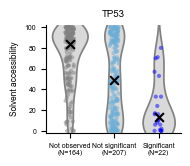

/tmp/ipykernel_1517215/2945031149.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby("EXON_RANK", group_keys=False).apply(lambda x: np.nan if sum(x.COVERED) == 0 else sum(x.DEPTH) / sum(x.COVERED))).drop(
/tmp/ipykernel_1517215/2945031149.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lambda x: x.groupby("EXON_RANK", group_keys=False).apply(lambda x: np.nan if sum(x.COVERED) == 0

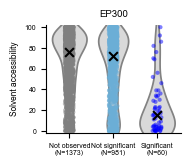

In [26]:
indels = False

for gene in ["TP53", "EP300"]:
    
    # Data
    # ====
    
    # Mut
    gene_mut = maf[maf["Gene"] == gene].drop(columns="Gene").reset_index(drop=True)
    gene_mut_count = maf_count[maf_count["Gene"] == gene].drop(columns="Gene").reset_index(drop=True)
    gene_mut_cnsq_count = maf_cnsq_count[maf_cnsq_count["Gene"] == gene].drop(columns="Gene").reset_index(drop=True)
    gene_cancer_mut = blca_cancer_df[blca_cancer_df["Gene"] == gene].drop(columns="Gene").reset_index(drop=True)
    gene_cancer_cnsq_count = blca_cancer_cnsq_count[blca_cancer_cnsq_count["Gene"] == gene]
    
    # Oncodrive3D
    o3d_gene_df = get_o3d_gene_data(gene, o3d_seq_df, o3d_df)
    uni_id = o3d_seq_df[o3d_seq_df["Gene"] == gene].Uniprot_ID.values[0]
    pdb_tool_gene = o3d_pdb_tool_df[o3d_pdb_tool_df["Uniprot_ID"] == uni_id].reset_index(drop=True)
    o3d_cancer_gene_df = o3d_cancer_df[o3d_cancer_df["Gene"] == gene].reset_index(drop=True)
    
    if indels == False:
        gene_mut_count = gene_mut_count[gene_mut_count["Consequence"] != "indel"].reset_index(drop=True)
        gene_mut = gene_mut[gene_mut["Consequence"] != "indel"].reset_index(drop=True)
        gene_cancer_mut = gene_cancer_mut[gene_cancer_mut["Consequence"] != "indel"].reset_index(drop=True)
        gene_mut_cnsq_count = gene_mut_cnsq_count[gene_mut_cnsq_count["Consequence"] != "indel"].reset_index(drop=True) 
        gene_cancer_cnsq_count = gene_cancer_cnsq_count[gene_cancer_cnsq_count["Consequence"] != "indel"].reset_index(drop=True) 
        
    prot_len = int(exons_depth[exons_depth["GENE"] == gene].PROT_POS.max())
    domain_gene = domain[domain["Gene"] == gene].reset_index(drop=True)
    
    # Max exons depth across all exons
    all_exons_depth = exons_depth[["GENE", "EXON_RANK", "DEPTH", "COVERED"]].groupby("GENE").apply(
        lambda x: x.groupby("EXON_RANK", group_keys=False).apply(lambda x: np.nan if sum(x.COVERED) == 0 else sum(x.DEPTH) / sum(x.COVERED))).drop(
        columns=["GENE", "EXON_RANK", "DEPTH", "COVERED"]).reset_index().rename(columns = {0 : "DEPTH"})
    max_depth = all_exons_depth.DEPTH.max()

    gene_exons_depth = exons_depth[exons_depth["GENE"] == gene].sort_values("DNA_POS")
    gene_exons_depth = gene_exons_depth.dropna(subset=["EXON_RANK"]).reset_index(drop=True)
    
    exon_selection_gene = exon_selection[exon_selection.gene.str.startswith(gene)]
    exon_selection_gene = exon_selection_gene.sort_values("exon_rank").reset_index(drop=True).rename(columns={"exon_rank" : "EXON_RANK"})
    exon_selection_gene = exon_selection_gene[["EXON_RANK", "impact", "dnds", "lower", "upper", "pvalue"]]

    site_selection_gene = site_selection[site_selection["GENE"] == gene].sort_values("Protein_position").reset_index(drop=True)

    domain_selection_gene = get_domain_selection_gene(domain_selection, domain_gene, gene)
    
    ddg_gene = get_ddg_gene(gene, gene_mut, o3d_annotations, o3d_seq_df, o3d_alt_seq_df)
    
    
    # Plot
    # ====
    
    plot_pars["fsize"] = (12.3, 11)
    lst_tracks=[
        "Mut_count", 
        "3d_clustering", 
        "Site_selection", 
        "Exon_selection", 
        "Solvent_accessibility", 
        "Res_depth", 
        "Domain", 
        "Cancer_mut_count"
        ]
    if gene in ["KDM6A", "STAG2"]:
        plot_pars["fsize"] = (12.3, 9)
        [lst_tracks.remove(track) for track in [
            "3d_clustering", 
            "Cancer_3d_clustering",
            "Solvent_accessibility", 
            "Stability_change",
            "Secondary_structure",
            ] if track in lst_tracks
        ]

    # Selection groups feat
    # =====================
    site_selection_gene_grouped = get_selection_groups(site_selection_gene, thr_selection=0.00001)
    site_selection_gene_grouped = site_selection_gene_grouped.merge(pdb_tool_gene[["Pos", "pACC"]])
    site_selection_gene_grouped = site_selection_gene_grouped.merge(ddg_gene) 
    plot_feat_by_selection_group(site_selection_gene_grouped, save=True, gene = gene, filename=f"plots/ExtendedFig10bc.{gene}.selection_groups.pdf")

### Main